# Time-Series Analysis of Criteria Pollutant Levels 
## Highlighting Lockdown Periods

In [93]:
# required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns
import openpyxl

# %matplotlib inline
# sns.set()
import datetime as dt
import matplotlib.dates
from matplotlib.ticker import NullFormatter
from matplotlib.dates import MonthLocator, DateFormatter
from  matplotlib import *
# from mpl_toolkits.basemap import Basemap
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# import glob
# from matplotlib.backends.backend_pdf import PdfPages

print ('Done')

Done


In [3]:
# get list of stations
stations_file = '~/Documents/GitHub/HMEI-2021/stations.csv'

df_stations = pd.read_csv(stations_file)
df_stations.head()

Full       Spaced     Key
0       Alipur, Delhi - DPCC       Alipur  Alipur
1  Anand Vihar, Delhi - DPCC  Anand Vihar   Anand
2  Ashok Vihar, Delhi - DPCC  Ashok Vihar   Ashok
3     Aya Nagar, Delhi - IMD    Aya Nagar     Aya
4       Bawana, Delhi - DPCC       Bawana  Bawana

In [4]:
# refer to stations by preset keys
stations = df_stations['Key']
print(stations)

0           Alipur
1            Anand
2            Ashok
3              Aya
4           Bawana
5           Burari
6             CRRI
7          Chandni
8              DTU
9            Karni
10          Dwarka
11       EastArjun
12             IGI
13           IHBAS
14             ITO
15    Jahangirpuri
16      Jawaharlal
17      Lodhi_ITTM
18       Lodhi_IMD
19           Major
20          Mandir
21          Mundka
22            NSIT
23       Najafgarh
24          Narela
25           Nehru
26           North
27           Okhla
28      Patparganj
29         Punjabi
30       Pusa_DPCC
31        PusaI_MD
32         RKPuram
33          Rohini
34        Shadipur
35        Sirifort
36           Sonia
37             Sri
38           Vivek
39        Wazirpur
Name: Key, dtype: object


In [5]:
# scratch work
example_path = '~/Documents/GitHub/HMEI-2021/example.xlsx'
example_df = pd.read_excel('~/Documents/GitHub/HMEI-2021/example.xlsx', skiprows=16)

example_df.head()

From Date           To Date   PM2.5    PM10   NO2    SO2  Ozone  \
0  01-01-2020 00:00  01-01-2020 01:00  707.25    None  3.55  17.05   15.8   
1  01-01-2020 01:00  01-01-2020 02:00     669    None  4.92   15.9  27.25   
2  01-01-2020 02:00  01-01-2020 03:00   596.5     991  4.18   14.3  17.55   
3  01-01-2020 03:00  01-01-2020 04:00     548  971.75  3.85   11.4  18.38   
4  01-01-2020 04:00  01-01-2020 05:00  548.75  899.75   3.2  11.43  27.07   

   Unnamed: 7  Unnamed: 8  
0         NaN         NaN  
1         NaN         NaN  
2         NaN         NaN  
3         NaN         NaN  
4         NaN         NaN

In [94]:
# use arbitrary station to get the list of datetime indices
alipur_str = '~/Documents/GitHub/HMEI-2021/station_data/data_Alipur.xlsx'
alipur_dat = pd.read_excel(alipur_str, skiprows=16)
time_index = pd.to_datetime(alipur_dat['From Date'])

In [95]:
# initialize df's for summarizing species data across stations
pm25_data = pd.DataFrame(index=time_index)
pm10_data = pd.DataFrame(index=time_index)
no2_data = pd.DataFrame(index=time_index)
so2_data = pd.DataFrame(index=time_index)
ozone_data = pd.DataFrame(index=time_index)

In [97]:
# stations with data downloaded
current_stations = ['Alipur', 'Anand', 'Ashok', 'Aya', 'Bawana', 'Dwarka', 'EastArjun', 'Karni', 'Narela', 'Nehru', \
                    'North', 'Okhla', 'Patparganj']

In [98]:
# clean and prep data

station_data = {} # dictionary to store each station's data
for station in current_stations:
    try:
        file_str = '~/Documents/GitHub/HMEI-2021/station_data/data_' + station + '.xlsx'
        df_station = pd.read_excel(file_str, skiprows=16)
        
        # drop unnamed columns
        df_station = df_station.drop(columns=list(df_station.filter(regex='Unnamed')))
        
        # set datetime as index
        df_station.index = pd.to_datetime(df_station['From Date'])
        df_station = df_station.drop(columns=['From Date', 'To Date'])
        
        if 'PM2.5' in df_station.columns:
            df_station = df_station.rename(columns={'PM2.5': 'PM25'})
        
        col_keep = []
        if 'PM25' in df_station.columns:
            pm25_data[station] = df_station['PM25']        # append station's data as column to species df
            col_keep.append(df_station['PM25'] != 'None')  # to filter out rows with missing data
        if 'PM10' in df_station.columns:
            pm10_data[station] = df_station['PM10']
            col_keep.append(df_station['PM10'] != 'None')
        if 'NO2' in df_station.columns:
            no2_data[station] = df_station['NO2']
            col_keep.append(df_station['NO2'] != 'None')
        if 'SO2' in df_station.columns:
            so2_data[station] = df_station['SO2']
            col_keep.append(df_station['SO2'] != 'None')
        if 'Ozone' in df_station.columns:
            ozone_data[station] = df_station['Ozone']
            col_keep.append(df_station['Ozone'] != 'None')
    
        cond_keep = [True for _ in range(len(df_station))]
        for cond in col_keep:
            cond_keep = cond_keep & cond
        
        df_station = df_station[cond_keep]
        
        # convert data to numeric
        for col in df_station.columns:
            df_station[col] = pd.to_numeric(df_station[col], errors='coerce')
        
        station_data[station] = df_station # add to dictionary
        
    except Exception as e:
        print(e, station)
        
print("Done")

Done


In [99]:
for station in station_data:
    print(station)
    print(station_data[station].shape) # observations, parameters

Alipur
(35153, 5)
Anand
(33942, 5)
Ashok
(36608, 5)
Aya
(39998, 4)
Bawana
(37434, 5)
Dwarka
(38406, 5)
EastArjun
(46050, 2)
Karni
(39162, 5)
Narela
(40952, 5)
Nehru
(35240, 5)
North
(41995, 4)
Okhla
(37933, 5)
Patparganj
(31442, 5)


In [105]:
# convert species data to numeric
for col in pm25_data.columns:
    pm25_data[col] = pd.to_numeric(pm25_data[col], errors='coerce')
    
for col in pm10_data.columns:
    pm10_data[col] = pd.to_numeric(pm10_data[col], errors='coerce')
    
for col in no2_data.columns:
    no2_data[col] = pd.to_numeric(no2_data[col], errors='coerce')
    
for col in so2_data.columns:
    so2_data[col] = pd.to_numeric(so2_data[col], errors='coerce')
    
for col in ozone_data.columns:
    ozone_data[col] = pd.to_numeric(ozone_data[col], errors='coerce')

In [160]:
def plotStationData(key):
    
    df = station_data[key]
    df_hourly = df.resample('H').mean()[:'2021-05-31']
    df_monthly = df.resample('M').mean()[:'2021-05-31']

    cols = df.columns
    
    first_date = df.index[0]
    last_date = df.index[-1]
    
    fig, axs = plt.subplots(len(cols), figsize=(20,20))

    for col, ax in zip(cols, axs):
          
        y1 = df_hourly[col] # df with hourly means
        ld1 = y1.loc['2020-03-24':'2020-05-31']
        ld2 = y1.loc['2021-04-19':'2021-05-31']
        y2 = df_monthly[col] # df with monthly means

        # Plotting hourly mean values in the backdrop
        ax.plot(y1, linestyle='', marker='o', color='grey', mec='grey', alpha=0.5, linewidth='2.5', \
                label='hourly mean')
        ax.plot(ld1, linestyle='', marker='o', color='red', mec='red', alpha=0.25, linewidth='2.5', \
                label='hourly mean')
        ax.plot(ld2, linestyle='', marker='o', color='red', mec='red', alpha=0.25, linewidth='2.5', \
                label='hourly mean')
        
        # Overlaying hourly mean values with monthly means
        ax.plot(y2, linestyle='--', color = 'black', linewidth='3.5') # monthly means as dotted lines
        ax.plot(y2, marker='o', markersize=25, linewidth=0,
             markerfacecolor='yellow',
             markeredgecolor='black',
             markeredgewidth=2, label='monthly mean') # monthly means as yellow dot
        
        if col == 'PM25':
            col = 'PM2.5'
        ax.set_ylabel(col + ' ($µg/m^3$)', fontsize=12)
        ax.set_title(col, fontsize=18)
        ax.set_xlim(first_date, last_date)
        
    plt.subplots_adjust(bottom=0.1, 
                        top=0.9, 
                        hspace=0.4)
    
    fig_title = 'Timeseries_' + key + '.tiff'
    # plt.savefig(fig_title, bbox_inches="tight")    

    print ('figure ready: ', fig_title)
    plt.show()    

figure ready:  Timeseries_Karni.tiff


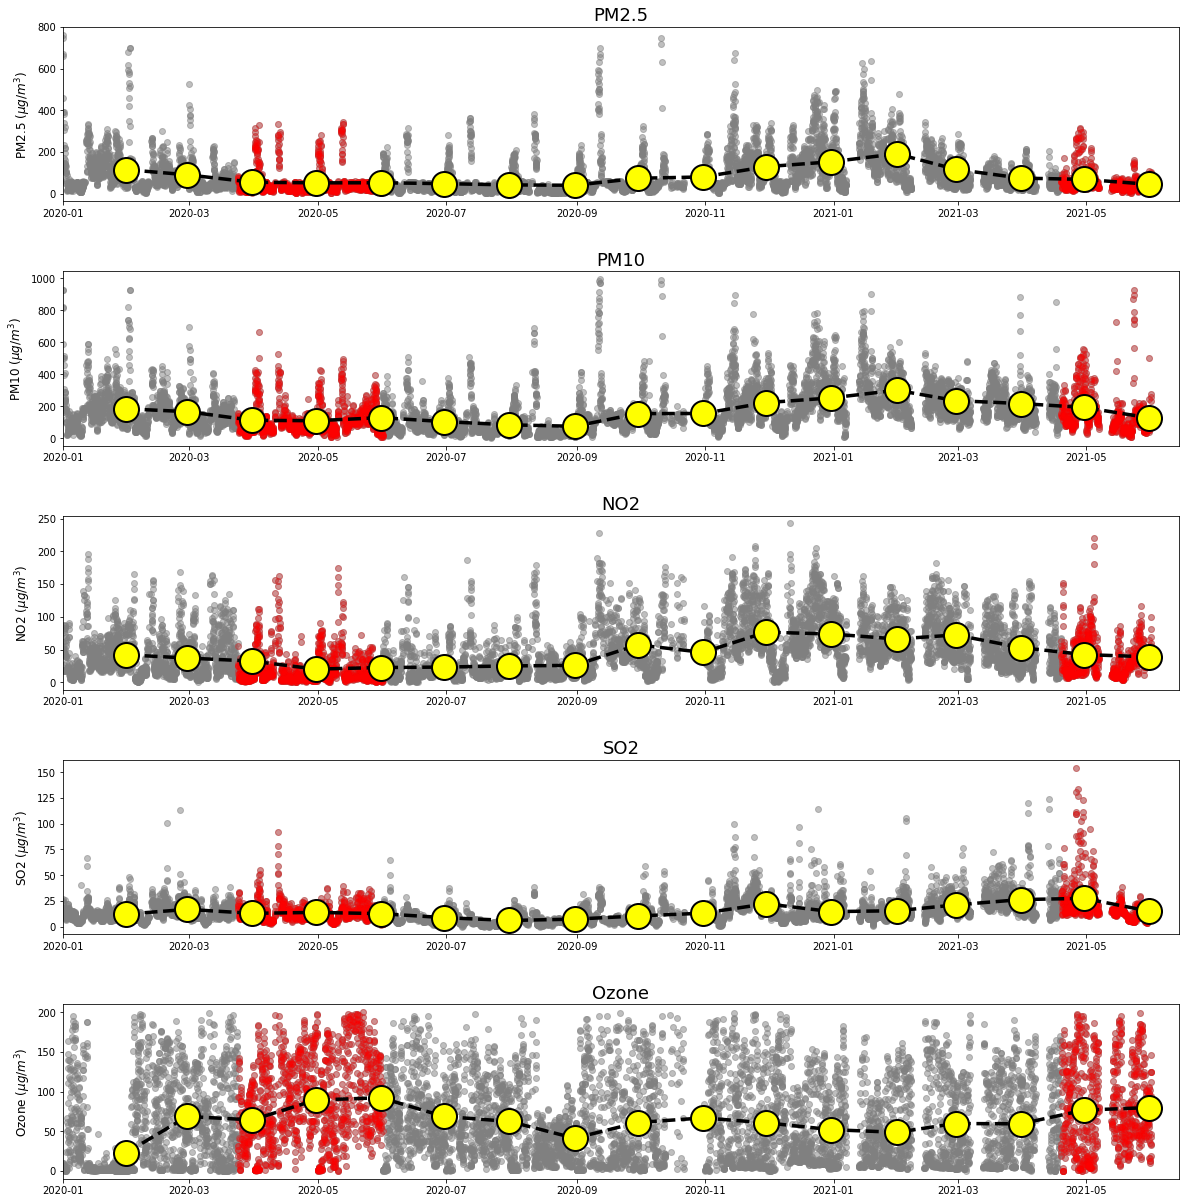

In [162]:
plotStationData('Karni')

In [163]:
def plotSpecies(pollutant):
    
    if pollutant == 'PM2.5':
        df = pm25_data
    elif pollutant == 'PM10':
        df = pm10_data
    elif pollutant == 'NO2':
        df = no2_data
    elif pollutant == 'SO2':
        df = so2_data
    elif pollutant == 'Ozone':
        df = ozone_data
    else:
        print('Pollutant not valid. Options: PM2.5, PM10, NO2, SO2, and Ozone.')
        return
    
    df_hourly = df.resample('H').mean()[:'2021-05-31']
    df_monthly = df.resample('M').mean()[:'2021-05-31']
    
    first_date = df.index[0]
    last_date = df.index[-1]
    
    fig, ax = plt.subplots(figsize=(20,10))
          
    y1 = df_hourly.mean(axis=1, skipna=True) # df with hourly mean values
    ld1 = y1.loc['2020-03-24':'2020-05-31']
    ld2 = y1.loc['2021-04-19':'2021-05-31']
    y2 = df_monthly.mean(axis=1, skipna=True) # df with monthly means

    # Plotting hourly mean values in the backdrop
    ax.plot(y1, linestyle='', marker='o', color='grey', mec='grey', alpha=0.5, linewidth='2.5', \
            label='hourly mean')
    ax.plot(ld1, linestyle='', marker='o', color='red', mec='red', alpha=0.25, linewidth='2.5', \
            label='hourly mean')
    ax.plot(ld2, linestyle='', marker='o', color='red', mec='red', alpha=0.25, linewidth='2.5', \
            label='hourly mean')

    # Overlaying hourly mean values with monthly means
    ax.plot(y2, linestyle='--', color = 'black', linewidth='3.5') # monthly means as dotted lines
    ax.plot(y2, marker='o', markersize=25, linewidth=0,
         markerfacecolor='yellow',
         markeredgecolor='black',
         markeredgewidth=2, label='monthly mean') # monthly means as yellow dot

    ax.set_ylabel(pollutant + ' ($µg/m^3$)', fontsize=12)
    ax.set_title(pollutant, fontsize=18)
    ax.set_xlim(first_date, last_date)
    
    fig_title = 'Timeseries_' + pollutant + '.tiff'
    # plt.savefig(fig_title, bbox_inches="tight")    

    print ('figure ready: ', fig_title)
    plt.show()    

figure ready:  Timeseries_PM2.5.tiff


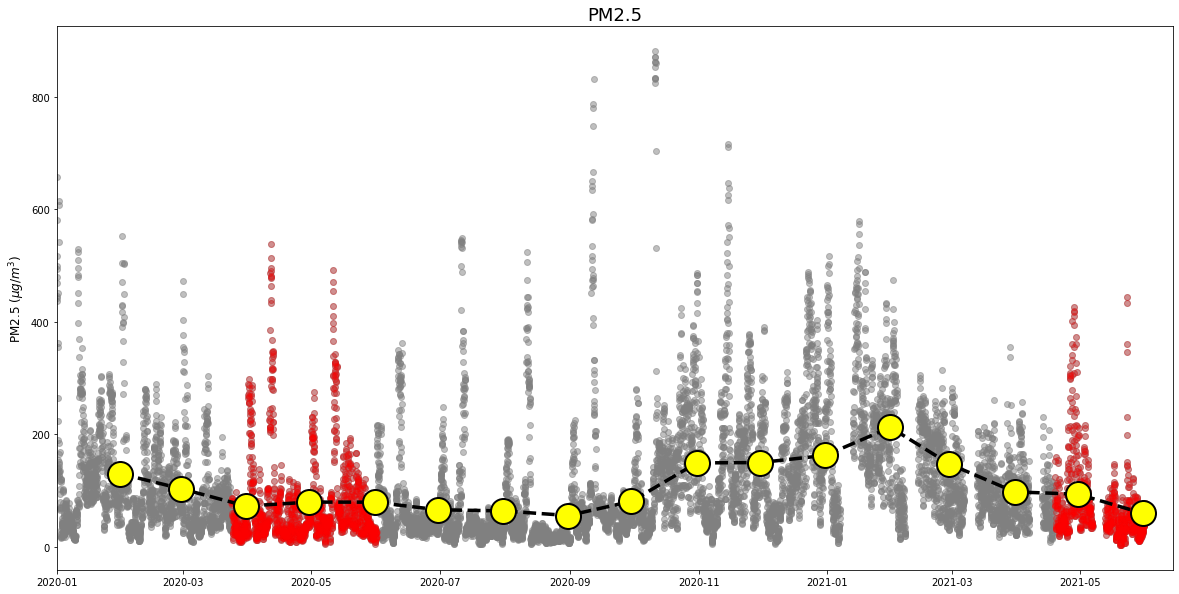

In [172]:
plotSpecies('PM2.5')

figure ready:  Timeseries_PM10.tiff


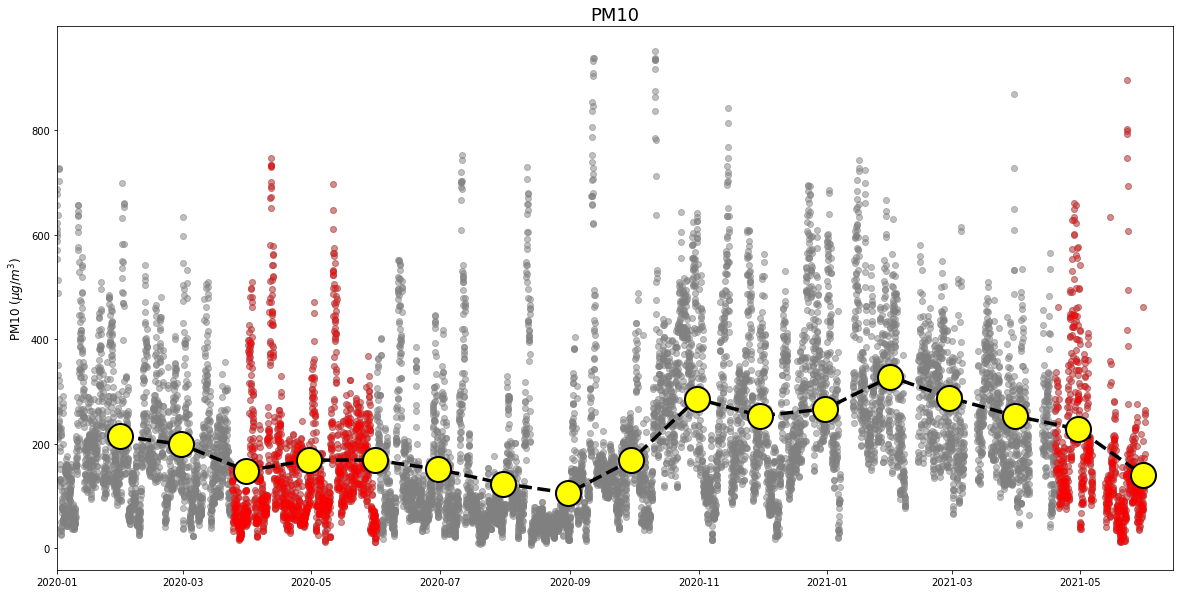

In [171]:
plotSpecies('PM10')

figure ready:  Timeseries_NO2.tiff


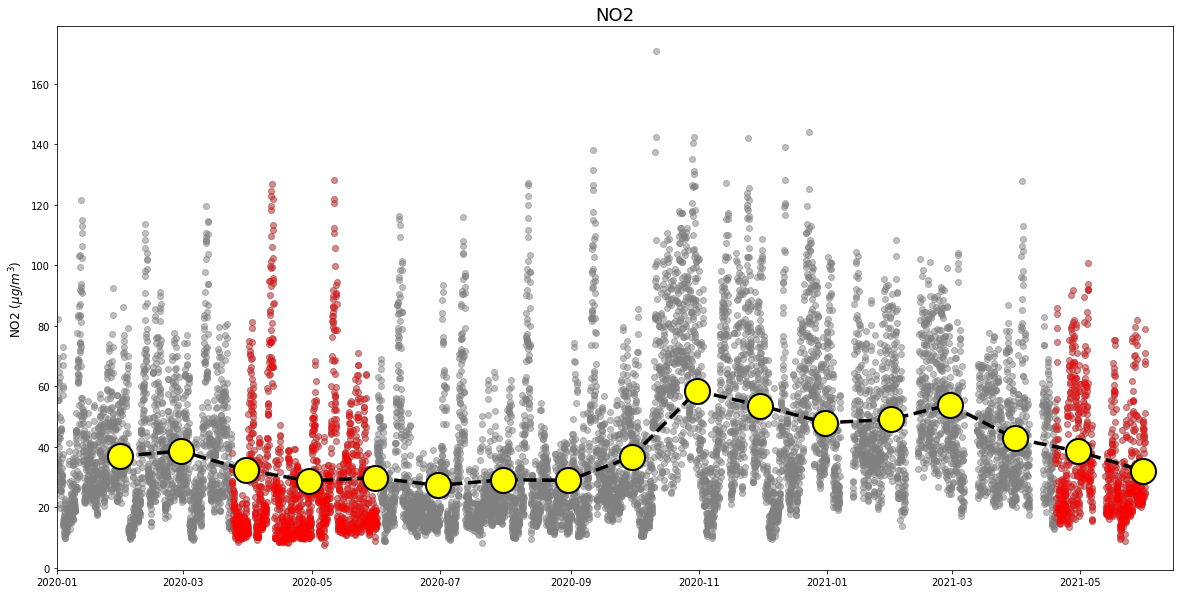

In [170]:
plotSpecies('NO2')

figure ready:  Timeseries_SO2.tiff


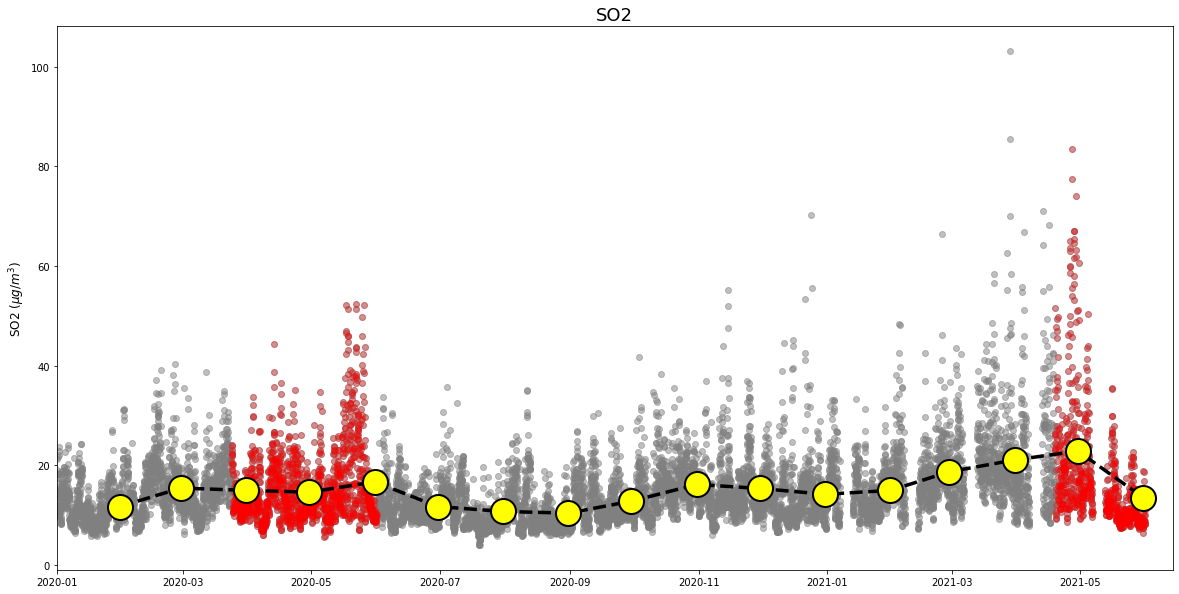

In [169]:
plotSpecies('SO2')

figure ready:  Timeseries_Ozone.tiff


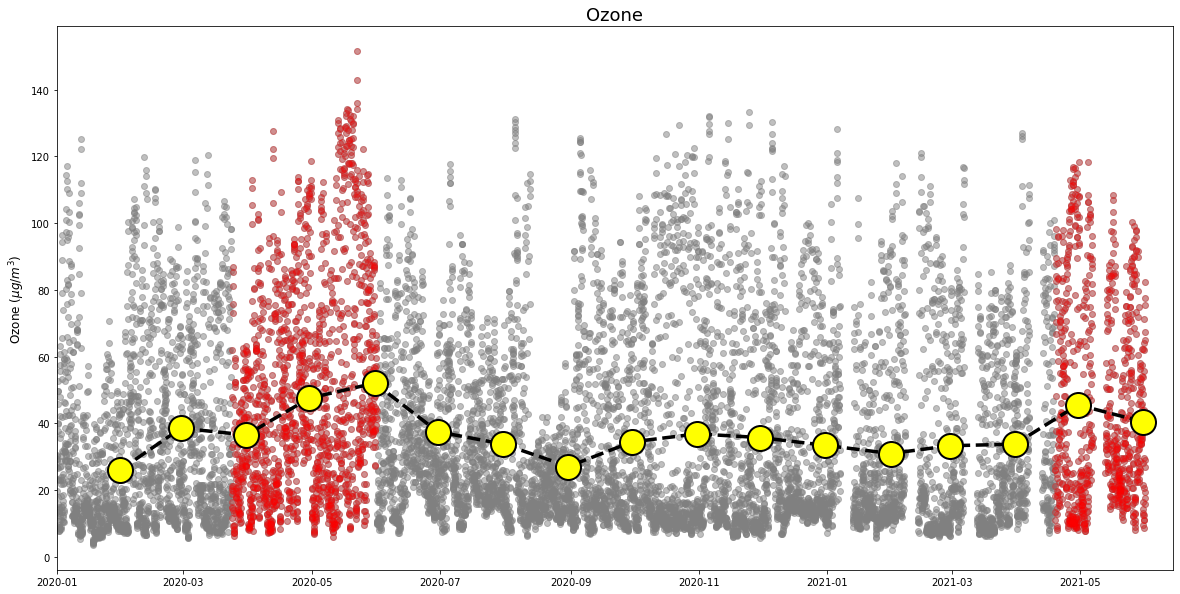

In [168]:
plotSpecies('Ozone')

In [157]:
station_data['Alipur'].resample('H').mean()[:'2021-05-31']

PM25   PM10        NO2        SO2      Ozone
From Date                                                              
2020-01-01 00:00:00  279.000000  344.0  61.750000  11.600000   1.650000
2020-01-01 01:00:00  267.000000  301.0  53.300000  12.000000   2.100000
2020-01-01 02:00:00  257.000000  305.0  47.950000   8.800000   2.200000
2020-01-01 03:00:00  311.500000  354.0  52.300000  11.200000   1.375000
2020-01-01 04:00:00  344.666667  405.0  49.866667  10.833333   1.200000
...                         ...    ...        ...        ...        ...
2021-05-31 19:00:00   42.000000  178.0  27.450000   8.075000  65.400000
2021-05-31 20:00:00   39.000000  248.0  30.600000  10.750000  49.875000
2021-05-31 21:00:00   61.000000  272.0  30.700000  12.275000  48.775000
2021-05-31 22:00:00   69.000000  263.0  34.366667  15.766667  34.933333
2021-05-31 23:00:00   89.000000  351.0  18.000000  22.550000  60.750000

[12408 rows x 5 columns]